참고한 글: https://3months.tistory.com/168

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.layers import LSTM, Dense, GRU, Dropout
from keras.models import Sequential
import keras.backend as K
from keras.callbacks import EarlyStopping

2022-10-31 15:42:14.763713: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [1]:
data = pd.read_csv('월별공급량및비중all.csv')
ind = data["도시가스(톤)_산업용"]
ind.index = pd.date_range("1996-01-01", "2020-12-01", freq="MS")
ind = ind.to_frame()
ind.columns=['gas']
ind.index = pd.DatetimeIndex(ind.index.values,
                               freq=ind.index.inferred_freq)
ind.plot()

<AxesSubplot:>

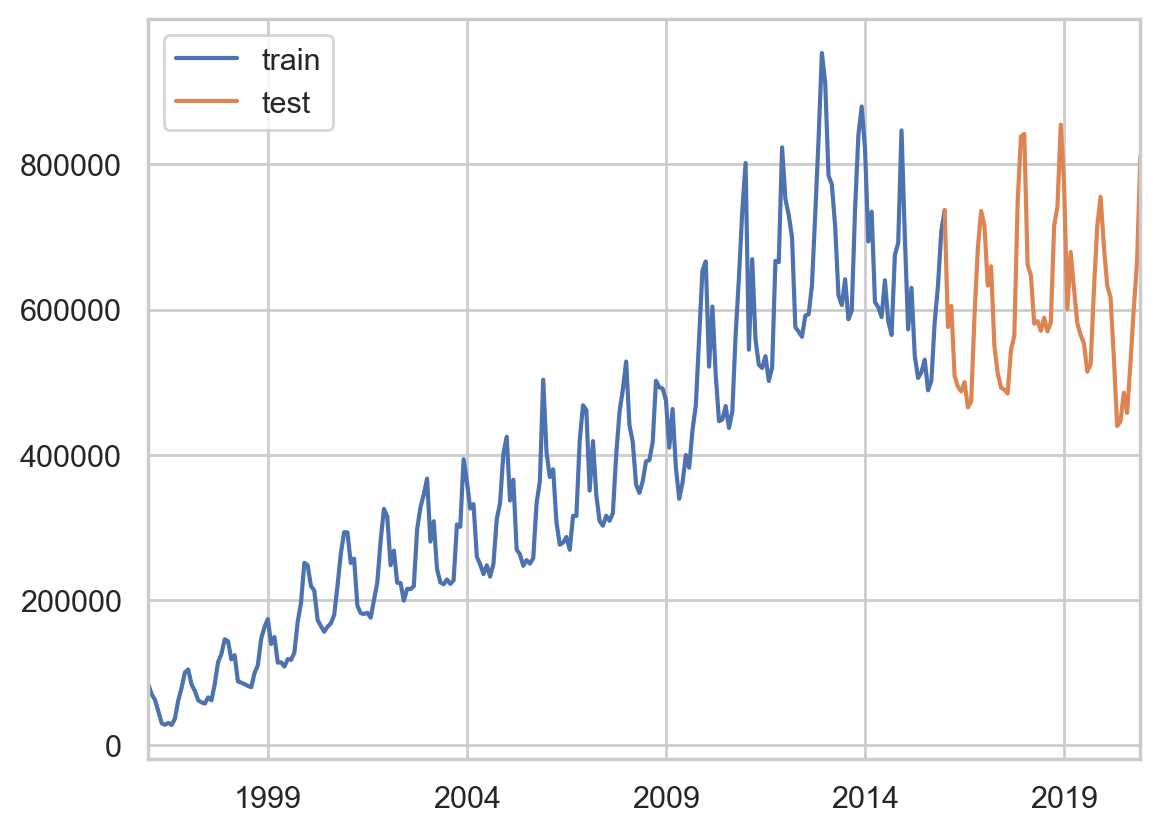

In [3]:
split_date = pd.Timestamp('01-01-2016')
train = ind.loc[:split_date]
test = ind.loc[split_date:]

ax = train.plot()
test.plot(ax=ax)
plt.legend(['train', 'test'])

In [4]:
sc = MinMaxScaler()

train_sc = sc.fit_transform(train)
test_sc = sc.transform(test)
train_sc, test_sc

(array([[6.01161880e-02],
        [4.56526791e-02],
        [3.72493177e-02],
        [2.03863925e-02],
        [2.72474263e-03],
        [3.73963090e-04],
        [3.16571645e-03],
        [0.00000000e+00],
        [9.49931098e-03],
        [3.64949066e-02],
        [5.52081926e-02],
        [7.82058418e-02],
        [8.27052879e-02],
        [6.04836661e-02],
        [5.07422519e-02],
        [3.69553352e-02],
        [3.37085574e-02],
        [3.18473885e-02],
        [4.11337783e-02],
        [3.66894539e-02],
        [6.09192359e-02],
        [9.33826907e-02],
        [1.05621876e-01],
        [1.27544111e-01],
        [1.24772893e-01],
        [9.76919128e-02],
        [1.03876354e-01],
        [6.48274744e-02],
        [6.31284282e-02],
        [6.06068794e-02],
        [5.82647464e-02],
        [5.61603934e-02],
        [7.74298144e-02],
        [8.91620957e-02],
        [1.28481180e-01],
        [1.45844524e-01],
        [1.57668675e-01],
        [1.20501500e-01],
        [1.3

In [5]:
train_sc_df = pd.DataFrame(train_sc, columns=['Scaled'], index=train.index)
test_sc_df = pd.DataFrame(test_sc, columns=['Scaled'], index=test.index)
train_sc_df.head(), test_sc_df.head()

(              Scaled
 1996-01-01  0.060116
 1996-02-01  0.045653
 1996-03-01  0.037249
 1996-04-01  0.020386
 1996-05-01  0.002725,
               Scaled
 2016-01-01  0.766104
 2016-02-01  0.592267
 2016-03-01  0.623713
 2016-04-01  0.519410
 2016-05-01  0.503349)

In [7]:
for s in range(1, 13):
    train_sc_df['shift_{}'.format(s)] = train_sc_df['Scaled'].shift(s)
    test_sc_df['shift_{}'.format(s)] = test_sc_df['Scaled'].shift(s)
    
train_sc_df.head(13)

,Scaled,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_7,shift_8,shift_9,shift_10,shift_11,shift_12
1996-01-01,0.060116,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-02-01,0.045653,0.060116,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-03-01,0.037249,0.045653,0.060116,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-04-01,0.020386,0.037249,0.045653,0.060116,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-05-01,0.002725,0.020386,0.037249,0.045653,0.060116,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-06-01,0.000374,0.002725,0.020386,0.037249,0.045653,0.060116,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-07-01,0.003166,0.000374,0.002725,0.020386,0.037249,0.045653,0.060116,NaN,NaN,NaN,NaN,NaN,NaN
1996-08-01,0.000000,0.003166,0.000374,0.002725,0.020386,0.037249,0.045653,0.060116,NaN,NaN,NaN,NaN,NaN
1996-09-01,0.009499,0.000000,0.003166,0.000374,0.002725,0.020386,0.037249,0.045653,0.060116,NaN,NaN,NaN,NaN
1996-10-01,0.036495,0.009499,0.000000,0.003166,0.000374,0.002725,0.020386,0.037249,0.045653,0.060116,NaN,NaN,NaN


In [7]:
X_train = train_sc_df.dropna().drop('Scaled', axis=1)
Y_train = train_sc_df.dropna()[['Scaled']]

X_test = test_sc_df.dropna().drop('Scaled', axis=1)
Y_test = test_sc_df.dropna()[['Scaled']]

X_train.head(), Y_train.head()

(             shift_1   shift_2   shift_3   shift_4   shift_5   shift_6  \
 1997-01-01  0.078206  0.055208  0.036495  0.009499  0.000000  0.003166   
 1997-02-01  0.082705  0.078206  0.055208  0.036495  0.009499  0.000000   
 1997-03-01  0.060484  0.082705  0.078206  0.055208  0.036495  0.009499   
 1997-04-01  0.050742  0.060484  0.082705  0.078206  0.055208  0.036495   
 1997-05-01  0.036955  0.050742  0.060484  0.082705  0.078206  0.055208   
 
              shift_7   shift_8   shift_9  shift_10  shift_11  shift_12  
 1997-01-01  0.000374  0.002725  0.020386  0.037249  0.045653  0.060116  
 1997-02-01  0.003166  0.000374  0.002725  0.020386  0.037249  0.045653  
 1997-03-01  0.000000  0.003166  0.000374  0.002725  0.020386  0.037249  
 1997-04-01  0.009499  0.000000  0.003166  0.000374  0.002725  0.020386  
 1997-05-01  0.036495  0.009499  0.000000  0.003166  0.000374  0.002725  ,
               Scaled
 1997-01-01  0.082705
 1997-02-01  0.060484
 1997-03-01  0.050742
 1997-04-01  0.

In [8]:
X_train = X_train.values
X_test = X_test.values
Y_train = Y_train.values
Y_test = Y_test.values

print(X_train.shape)
print(X_train)
print(Y_train.shape)
print(Y_train)

(229, 12)
[[0.07820584 0.05520819 0.03649491 ... 0.03724932 0.04565268 0.06011619]
 [0.08270529 0.07820584 0.05520819 ... 0.02038639 0.03724932 0.04565268]
 [0.06048367 0.08270529 0.07820584 ... 0.00272474 0.02038639 0.03724932]
 ...
 [0.59956551 0.51238239 0.49797401 ... 0.72671512 0.88477181 0.71725796]
 [0.65438677 0.59956551 0.51238239 ... 0.58870113 0.72671512 0.88477181]
 [0.73544057 0.65438677 0.59956551 ... 0.6505196  0.58870113 0.72671512]]
(229, 1)
[[0.08270529]
 [0.06048367]
 [0.05074225]
 [0.03695534]
 [0.03370856]
 [0.03184739]
 [0.04113378]
 [0.03668945]
 [0.06091924]
 [0.09338269]
 [0.10562188]
 [0.12754411]
 [0.12477289]
 [0.09769191]
 [0.10387635]
 [0.06482747]
 [0.06312843]
 [0.06060688]
 [0.05826475]
 [0.05616039]
 [0.07742981]
 [0.0891621 ]
 [0.12848118]
 [0.14584452]
 [0.15766868]
 [0.1205015 ]
 [0.13100273]
 [0.09280445]
 [0.09334378]
 [0.08702532]
 [0.09804858]
 [0.09687914]
 [0.10771542]
 [0.15348699]
 [0.18190062]
 [0.2413467 ]
 [0.2378643 ]
 [0.20687292]
 [0.2

In [9]:
X_train_t = X_train.reshape(X_train.shape[0], 12, 1)
X_test_t = X_test.reshape(X_test.shape[0], 12, 1)
print("최종 DATA")
print(X_train_t.shape)
print(X_train_t)
print(Y_train)

최종 DATA
(229, 12, 1)
[[[0.07820584]
  [0.05520819]
  [0.03649491]
  ...
  [0.03724932]
  [0.04565268]
  [0.06011619]]

 [[0.08270529]
  [0.07820584]
  [0.05520819]
  ...
  [0.02038639]
  [0.03724932]
  [0.04565268]]

 [[0.06048367]
  [0.08270529]
  [0.07820584]
  ...
  [0.00272474]
  [0.02038639]
  [0.03724932]]

 ...

 [[0.59956551]
  [0.51238239]
  [0.49797401]
  ...
  [0.72671512]
  [0.88477181]
  [0.71725796]]

 [[0.65438677]
  [0.59956551]
  [0.51238239]
  ...
  [0.58870113]
  [0.72671512]
  [0.88477181]]

 [[0.73544057]
  [0.65438677]
  [0.59956551]
  ...
  [0.6505196 ]
  [0.58870113]
  [0.72671512]]]
[[0.08270529]
 [0.06048367]
 [0.05074225]
 [0.03695534]
 [0.03370856]
 [0.03184739]
 [0.04113378]
 [0.03668945]
 [0.06091924]
 [0.09338269]
 [0.10562188]
 [0.12754411]
 [0.12477289]
 [0.09769191]
 [0.10387635]
 [0.06482747]
 [0.06312843]
 [0.06060688]
 [0.05826475]
 [0.05616039]
 [0.07742981]
 [0.0891621 ]
 [0.12848118]
 [0.14584452]
 [0.15766868]
 [0.1205015 ]
 [0.13100273]
 [0.092

In [10]:
print(X_train_t.shape[1:])

(12, 1)


In [11]:
K.clear_session()

model = Sequential()
model.add(LSTM(300, input_shape=(12,1), return_sequences=True, activation='relu'))
model.add(Dropout(0.2))
model.add(LSTM(300, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 12, 300)           362400    
                                                                 
 dropout (Dropout)           (None, 12, 300)           0         
                                                                 
 lstm_1 (LSTM)               (None, 300)               721200    
                                                                 
 dense (Dense)               (None, 1)                 301       
                                                                 
Total params: 1,083,901
Trainable params: 1,083,901
Non-trainable params: 0
_________________________________________________________________


In [12]:
early_stop = EarlyStopping(monitor='loss', patience=50, verbose=1)
h = model.fit(X_train_t, Y_train, epochs=300, validation_data=[X_test_t, Y_test],
         batch_size=10, verbose=1, callbacks=[early_stop])

Epoch 1/300
23/23 [==============================] - 4s 77ms/step - loss: 0.0471 - val_loss: 0.0264
Epoch 2/300
23/23 [==============================] - 1s 56ms/step - loss: 0.0125 - val_loss: 0.0148
Epoch 3/300
23/23 [==============================] - 1s 47ms/step - loss: 0.0083 - val_loss: 0.0192
Epoch 4/300
23/23 [==============================] - 1s 58ms/step - loss: 0.0100 - val_loss: 0.0173
Epoch 5/300
23/23 [==============================] - 1s 59ms/step - loss: 0.0090 - val_loss: 0.0138
Epoch 6/300
23/23 [==============================] - 1s 54ms/step - loss: 0.0082 - val_loss: 0.0132
Epoch 7/300
23/23 [==============================] - 1s 50ms/step - loss: 0.0077 - val_loss: 0.0161
Epoch 8/300
23/23 [==============================] - 1s 54ms/step - loss: 0.0073 - val_loss: 0.0129
Epoch 9/300
23/23 [==============================] - 1s 51ms/step - loss: 0.0072 - val_loss: 0.0115
Epoch 10/300
23/23 [==============================] - 1s 55ms/step - loss: 0.0065 - val_loss: 0.0154

23/23 [==============================] - 1s 61ms/step - loss: 0.0019 - val_loss: 0.0027
Epoch 163/300
23/23 [==============================] - 1s 61ms/step - loss: 0.0018 - val_loss: 0.0025
Epoch 164/300
23/23 [==============================] - 1s 61ms/step - loss: 0.0018 - val_loss: 0.0022
Epoch 165/300
23/23 [==============================] - 1s 63ms/step - loss: 0.0021 - val_loss: 0.0022
Epoch 166/300
23/23 [==============================] - 1s 61ms/step - loss: 0.0019 - val_loss: 0.0023
Epoch 167/300
23/23 [==============================] - 1s 61ms/step - loss: 0.0020 - val_loss: 0.0025
Epoch 168/300
23/23 [==============================] - 1s 61ms/step - loss: 0.0018 - val_loss: 0.0025
Epoch 169/300
23/23 [==============================] - 1s 62ms/step - loss: 0.0020 - val_loss: 0.0036
Epoch 170/300
23/23 [==============================] - 1s 62ms/step - loss: 0.0022 - val_loss: 0.0039
Epoch 171/300
23/23 [==============================] - 1s 62ms/step - loss: 0.0022 - val_loss: 0

Minimum Train Loss: 0.0012
Minimum Validation Loss: 0.0018
dict_keys(['loss', 'val_loss'])


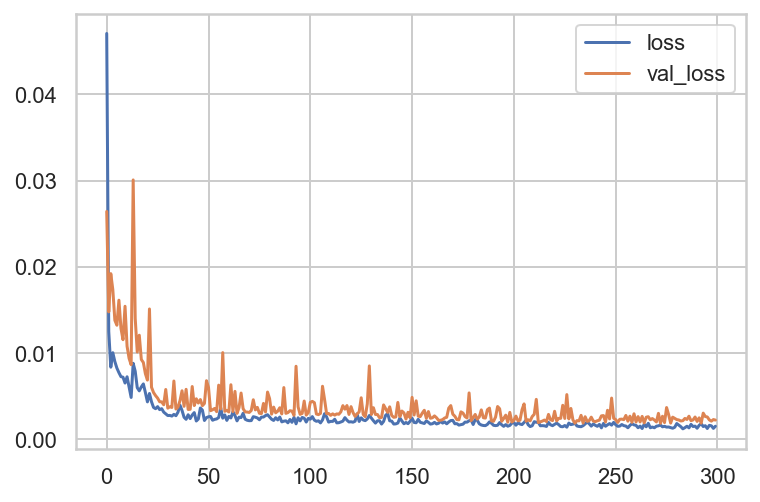

In [13]:
history_df=pd.DataFrame(h.history)
print("Minimum Train Loss: {:0.4f}".format(history_df['loss'].min()))
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()))

print(h.history.keys())
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.legend(['loss','val_loss'])
plt.show()

In [14]:
Y_pred = model.predict(X_test_t)
print("Loss: ", model.evaluate(X_test_t,Y_test))
print(Y_pred)
print(Y_test)

2/2 [==============================] - 0s 13ms/step - loss: 0.0022
Loss:  0.002212315099313855
[[0.779814  ]
 [0.6565796 ]
 [0.63207996]
 [0.59037054]
 [0.54753137]
 [0.5386385 ]
 [0.5393636 ]
 [0.5305675 ]
 [0.5262058 ]
 [0.61411476]
 [0.6860502 ]
 [0.80500937]
 [0.868464  ]
 [0.7589029 ]
 [0.7332194 ]
 [0.6524954 ]
 [0.584707  ]
 [0.57846224]
 [0.57474685]
 [0.562449  ]
 [0.58963335]
 [0.66539097]
 [0.8145988 ]
 [0.860471  ]
 [0.80963564]
 [0.7207279 ]
 [0.6989622 ]
 [0.6089034 ]
 [0.5808089 ]
 [0.5769704 ]
 [0.57864654]
 [0.5635692 ]
 [0.57675946]
 [0.6314845 ]
 [0.7046083 ]
 [0.7837517 ]
 [0.80523217]
 [0.6623254 ]
 [0.63522685]
 [0.58101416]
 [0.5476818 ]
 [0.5386882 ]
 [0.54730666]
 [0.54131126]
 [0.54470944]
 [0.62985706]
 [0.7123387 ]
 [0.79277146]]
[[0.74299549]
 [0.65386474]
 [0.68268367]
 [0.56364992]
 [0.5236175 ]
 [0.50194061]
 [0.49926883]
 [0.49324543]
 [0.55852252]
 [0.57889486]
 [0.7766446 ]
 [0.87593288]
 [0.87960874]
 [0.68494799]
 [0.66906752]
 [0.59712935]
 [0.6011

In [15]:
y_pred = sc.inverse_transform(Y_pred)
y_test = sc.inverse_transform(Y_test)
print(y_pred, y_test)

[[749691.4 ]
 [635671.9 ]
 [613004.2 ]
 [574413.56]
 [534777.7 ]
 [526549.75]
 [527220.7 ]
 [519082.3 ]
 [515046.72]
 [596382.3 ]
 [662938.75]
 [773002.75]
 [831712.56]
 [730343.94]
 [706580.9 ]
 [631893.  ]
 [569173.56]
 [563395.7 ]
 [559958.1 ]
 [548579.8 ]
 [573731.5 ]
 [643824.3 ]
 [781875.1 ]
 [824317.25]
 [777283.1 ]
 [695023.5 ]
 [674885.3 ]
 [591560.6 ]
 [565566.9 ]
 [562015.44]
 [563566.25]
 [549616.25]
 [561820.25]
 [612453.25]
 [680109.2 ]
 [753334.7 ]
 [773208.94]
 [640988.  ]
 [615915.75]
 [565756.8 ]
 [534916.9 ]
 [526595.75]
 [534569.75]
 [529022.7 ]
 [532166.75]
 [610947.5 ]
 [687261.56]
 [761679.94]] [[715626.]
 [633160.]
 [659824.]
 [549691.]
 [512652.]
 [492596.]
 [490124.]
 [484551.]
 [544947.]
 [563796.]
 [746759.]
 [838623.]
 [842024.]
 [661919.]
 [647226.]
 [580667.]
 [584369.]
 [570856.]
 [589012.]
 [569973.]
 [582462.]
 [715571.]
 [741783.]
 [854757.]
 [772539.]
 [600861.]
 [679395.]
 [627743.]
 [581306.]
 [565142.]
 [553295.]
 [514526.]
 [524795.]
 [628223.]
 

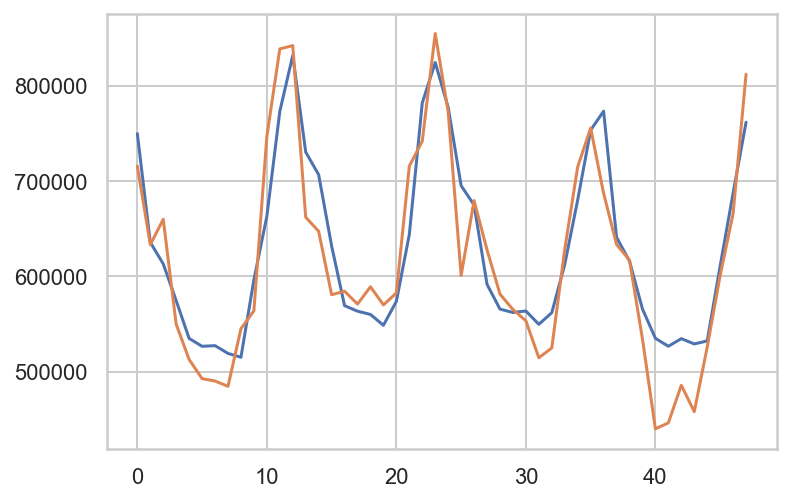

In [16]:
plt.figure()
plt.plot(y_pred)
plt.plot(y_test)

In [17]:
print(test_sc_df['2020-12-01':])
print(test_sc_df['2020-12-01':].shift(axis=1).drop('Scaled', axis=1).values)

new_X = test_sc_df['2020-12-01':].shift(axis=1).drop('Scaled', axis=1).values
new_X_t = new_X.reshape(new_X.shape[0], 12, 1)
print('new_X: ', new_X)
print('new_X_t: ', new_X_t)
print(new_X_t.shape)
print(type(new_X_t))

             Scaled   shift_1   shift_2   shift_3   shift_4   shift_5  \
2020-12-01  0.84708  0.689252  0.618987  0.537632  0.464516  0.494435   

             shift_6   shift_7   shift_8   shift_9  shift_10  shift_11  \
2020-12-01  0.451833  0.445039  0.547036  0.636397   0.65412  0.712147   

            shift_12  
2020-12-01  0.786142  
[[0.84708044 0.6892518  0.61898673 0.53763247 0.4645162  0.49443541
  0.4518328  0.44503877 0.54703559 0.63639655 0.65411981 0.71214678]]
new_X:  [[0.84708044 0.6892518  0.61898673 0.53763247 0.4645162  0.49443541
  0.4518328  0.44503877 0.54703559 0.63639655 0.65411981 0.71214678]]
new_X_t:  [[[0.84708044]
  [0.6892518 ]
  [0.61898673]
  [0.53763247]
  [0.4645162 ]
  [0.49443541]
  [0.4518328 ]
  [0.44503877]
  [0.54703559]
  [0.63639655]
  [0.65411981]
  [0.71214678]]]
(1, 12, 1)
<class 'numpy.ndarray'>


In [18]:
new_Y_pred = model.predict(new_X_t)
new_Y_pred

1/1 [==============================] - 0s 28ms/step


array([[0.8213161]], dtype=float32)

In [19]:
test_sc_df['2020-12-01':]

,Scaled,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_7,shift_8,shift_9,shift_10,shift_11,shift_12
2020-12-01,0.84708,0.689252,0.618987,0.537632,0.464516,0.494435,0.451833,0.445039,0.547036,0.636397,0.65412,0.712147,0.786142


In [20]:
from pandas.tseries.offsets import DateOffset
pred_date = [test_sc_df.index[-1] + DateOffset(months=x) for x in range(0,169)]
pred_date = pd.DataFrame(index=pred_date[1:], columns=test_sc_df.columns)
pred_date.iloc[0,1:] = test_sc_df['2020-12-01':].shift(axis=1).drop('Scaled', axis=1)
print(pred_date)

new_X = np.reshape(pred_date.iloc[0,1:].values, (-1, 12, 1))
new_X = np.asarray(new_X).astype('float32')
print(new_X.shape)
print('new_X: ', new_X)

           Scaled  shift_1   shift_2   shift_3   shift_4   shift_5   shift_6  \
2021-01-01    NaN  0.84708  0.689252  0.618987  0.537632  0.464516  0.494435   
2021-02-01    NaN      NaN       NaN       NaN       NaN       NaN       NaN   
2021-03-01    NaN      NaN       NaN       NaN       NaN       NaN       NaN   
2021-04-01    NaN      NaN       NaN       NaN       NaN       NaN       NaN   
2021-05-01    NaN      NaN       NaN       NaN       NaN       NaN       NaN   
...           ...      ...       ...       ...       ...       ...       ...   
2034-08-01    NaN      NaN       NaN       NaN       NaN       NaN       NaN   
2034-09-01    NaN      NaN       NaN       NaN       NaN       NaN       NaN   
2034-10-01    NaN      NaN       NaN       NaN       NaN       NaN       NaN   
2034-11-01    NaN      NaN       NaN       NaN       NaN       NaN       NaN   
2034-12-01    NaN      NaN       NaN       NaN       NaN       NaN       NaN   

             shift_7   shift_8   shift_

In [21]:
new_Y_pred = model.predict(new_X)
new_Y_pred

1/1 [==============================] - 0s 30ms/step


array([[0.8213161]], dtype=float32)

In [22]:
pred_date.iloc[0,0] = new_Y_pred[0][0]
pred_date

,Scaled,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_7,shift_8,shift_9,shift_10,shift_11,shift_12
2021-01-01,0.821316,0.84708,0.689252,0.618987,0.537632,0.464516,0.494435,0.451833,0.445039,0.547036,0.636397,0.65412,0.712147
2021-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2034-08-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2034-09-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2034-10-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2034-11-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
for i in range(1, 168):
    pred_date.iloc[i, 1:] = pred_date.iloc[i-1][:-1].values
    new_X = np.reshape(pred_date.iloc[i, 1:].values, (-1, 12, 1))
    new_X = np.asarray(new_X).astype('float32')
    new_Y_pred = model.predict(new_X)
    pred_date.iloc[i,0] = new_Y_pred[0][0]
pred_date

1/1 [==============================] - 0s 23ms/step


,Scaled,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_7,shift_8,shift_9,shift_10,shift_11,shift_12
2021-01-01,0.821316,0.84708,0.689252,0.618987,0.537632,0.464516,0.494435,0.451833,0.445039,0.547036,0.636397,0.65412,0.712147
2021-02-01,0.718741,0.821316,0.84708,0.689252,0.618987,0.537632,0.464516,0.494435,0.451833,0.445039,0.547036,0.636397,0.65412
2021-03-01,0.695578,0.718741,0.821316,0.84708,0.689252,0.618987,0.537632,0.464516,0.494435,0.451833,0.445039,0.547036,0.636397
2021-04-01,0.642034,0.695578,0.718741,0.821316,0.84708,0.689252,0.618987,0.537632,0.464516,0.494435,0.451833,0.445039,0.547036
2021-05-01,0.581839,0.642034,0.695578,0.718741,0.821316,0.84708,0.689252,0.618987,0.537632,0.464516,0.494435,0.451833,0.445039
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2034-08-01,0.631941,0.665315,0.716151,0.803695,0.782544,0.700427,0.626792,0.564267,0.552693,0.563756,0.563981,0.567824,0.614108
2034-09-01,0.577104,0.631941,0.665315,0.716151,0.803695,0.782544,0.700427,0.626792,0.564267,0.552693,0.563756,0.563981,0.567824
2034-10-01,0.562855,0.577104,0.631941,0.665315,0.716151,0.803695,0.782544,0.700427,0.626792,0.564267,0.552693,0.563756,0.563981
2034-11-01,0.563702,0.562855,0.577104,0.631941,0.665315,0.716151,0.803695,0.782544,0.700427,0.626792,0.564267,0.552693,0.563756


<AxesSubplot:>

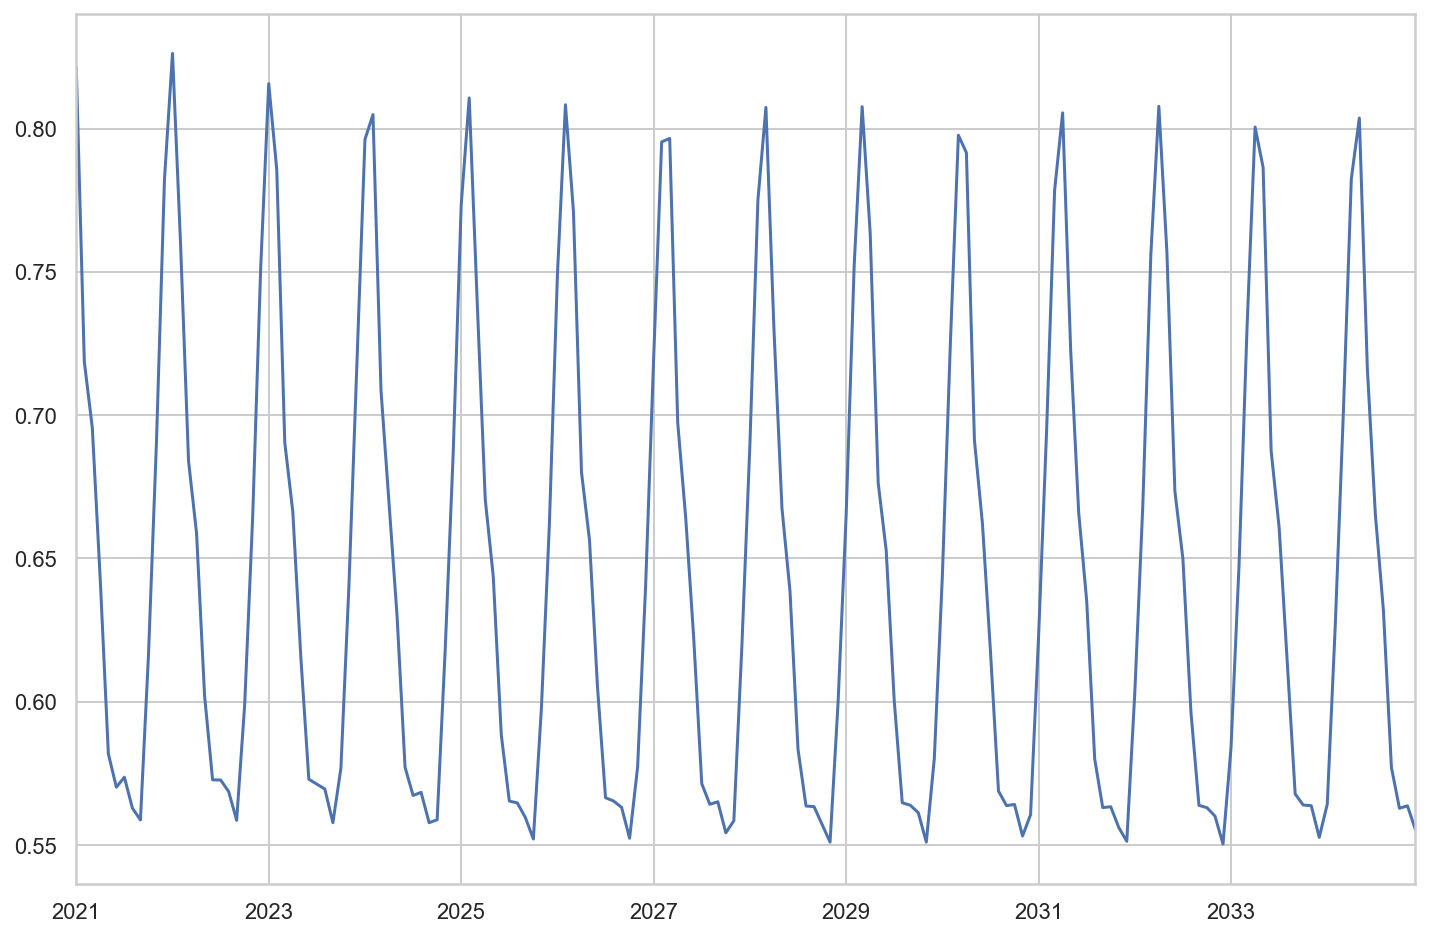

In [24]:
pred_date['Scaled'].plot(figsize=(12,8))

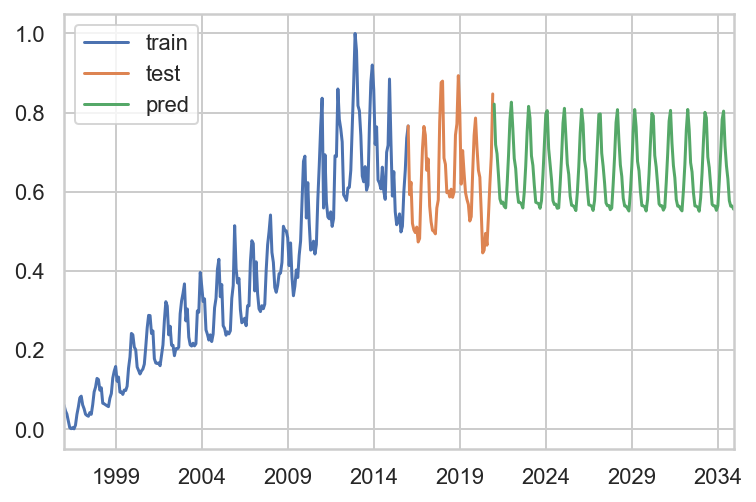

In [25]:
train_sc_df['Scaled'].plot()
test_sc_df['Scaled'].plot()
pred_date['Scaled'].plot()
plt.legend(['train', 'test','pred'])

In [26]:
tmp = np.reshape(pred_date['Scaled'].values, (1, -1))
pred = sc.inverse_transform(tmp)
pred_date['final'] = pred.flatten()
pred_date

,Scaled,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_7,shift_8,shift_9,shift_10,shift_11,shift_12,final
2021-01-01,0.821316,0.84708,0.689252,0.618987,0.537632,0.464516,0.494435,0.451833,0.445039,0.547036,0.636397,0.65412,0.712147,788090.209911
2021-02-01,0.718741,0.821316,0.84708,0.689252,0.618987,0.537632,0.464516,0.494435,0.451833,0.445039,0.547036,0.636397,0.65412,693185.417185
2021-03-01,0.695578,0.718741,0.821316,0.84708,0.689252,0.618987,0.537632,0.464516,0.494435,0.451833,0.445039,0.547036,0.636397,671754.466588
2021-04-01,0.642034,0.695578,0.718741,0.821316,0.84708,0.689252,0.618987,0.537632,0.464516,0.494435,0.451833,0.445039,0.547036,622213.516248
2021-05-01,0.581839,0.642034,0.695578,0.718741,0.821316,0.84708,0.689252,0.618987,0.537632,0.464516,0.494435,0.451833,0.445039,566520.397959
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2034-08-01,0.631941,0.665315,0.716151,0.803695,0.782544,0.700427,0.626792,0.564267,0.552693,0.563756,0.563981,0.567824,0.614108,612875.796125
2034-09-01,0.577104,0.631941,0.665315,0.716151,0.803695,0.782544,0.700427,0.626792,0.564267,0.552693,0.563756,0.563981,0.567824,562139.022896
2034-10-01,0.562855,0.577104,0.631941,0.665315,0.716151,0.803695,0.782544,0.700427,0.626792,0.564267,0.552693,0.563756,0.563981,548955.963427
2034-11-01,0.563702,0.562855,0.577104,0.631941,0.665315,0.716151,0.803695,0.782544,0.700427,0.626792,0.564267,0.552693,0.563756,549739.171169


In [27]:
final = pd.read_csv('lstm.csv')
final['IND'] = pred_date['final'].values
final

,YEAR,MONTH,CIVIL,IND
0,2021,1,1.910935e+06,788090.209911
1,2021,2,1.607537e+06,693185.417185
2,2021,3,1.290014e+06,671754.466588
3,2021,4,8.713010e+05,622213.516248
4,2021,5,4.969926e+05,566520.397959
...,...,...,...,...
163,2034,8,3.641802e+05,612875.796125
164,2034,9,6.061673e+05,562139.022896
165,2034,10,1.198691e+06,548955.963427
166,2034,11,1.906855e+06,549739.171169


In [28]:
final.to_csv("lstm.csv", mode='w', index=False)

In [29]:
# model.save('lstm_ind.h5')